In [4]:
import simpy
import pathlib
import networkx as nx
import datetime

import itertools
import requests
import pickle
import io
import shapely
import pandas as pd
import geopandas as gpd

import numpy as np
import simpy

import opentnsim
import opentnsim.core as core
import opentnsim.utils

import itertools

import matplotlib.pyplot as plt

import pint
import time

ureg = pint.UnitRegistry()

In [5]:
write_dir = pathlib.Path('~').expanduser().resolve() / 'projects/trans2/deliverables/hubs-spokes'
fig_dir = write_dir / 'figures'
fig_dir.mkdir(exist_ok=True)

In [6]:
url = "https://zenodo.org/records/6673604/files/network_digital_twin_v0.3.pickle?download=1"
resp = requests.get(url)

In [7]:
graph = pickle.load(io.BytesIO(resp.content))
for n, node in graph.nodes.items():
    node["geometry"] = shapely.from_wkt(node["Wkt"])

for e, edge in graph.edges.items():
    edge["geometry"] = shapely.from_wkt(edge["Wkt"])

import pathlib

src_dir = (
    pathlib.Path("~").expanduser().resolve()
    / "projects/trans2/digitaltwin-waterway/notebooks/scenarios"
)
trips_gdf = gpd.read_parquet(src_dir / "week_38_routes.parquet")

In [8]:
nodes = {
    "Nijmegen": "22638188",
    "Duisburg": "FN96",
    "Rotterdam": "18008346",
}

In [9]:
def get_route_gdfs(a, b):
    # Use shortest path algorithm for route from a to b
    route = nx.shortest_path(graph, source=a, target=b, weight="length_m")

    nodes = []
    for n in route:
        node = graph.nodes[n]
        nodes.append(node)

    node_df = pd.DataFrame(nodes)
    geometry = gpd.GeoSeries.from_wkt(node_df["Wkt"])
    node_gdf = gpd.GeoDataFrame(node_df, geometry=geometry)

    edges = []
    # loop over edges in route and add to list
    for a, b in zip(route[:-1], route[1:]):
        edge = graph.edges[(a, b)].copy()
        edge_a, edge_b = edge["geometry"].boundary.geoms

        distance_a_a = edge_a.distance(graph.nodes[a]["geometry"])
        distance_a_b = edge_b.distance(graph.nodes[a]["geometry"])

        if distance_a_a > distance_a_b:
            edge_inverted = True
        edge["inverted"] = edge_inverted
        edges.append(edge)

    edge_df = pd.DataFrame(edges)
    geometry = gpd.GeoSeries.from_wkt(edge_df["Wkt"])

    edge_gdf = gpd.GeoDataFrame(edge_df, geometry=geometry)
    edge_gdf["geometry"] = edge_gdf.apply(
        lambda row: row["geometry"].reverse() if row["inverted"] else row["geometry"],
        axis=1,
    )

    result = {"edge": edge_gdf, "node": node_gdf}
    return result


route_gdfs = get_route_gdfs(nodes["Nijmegen"], nodes["Duisburg"])
edge_gdf = route_gdfs["edge"]
node_gdf = route_gdfs["node"]

max_capacity = trips_gdf["v30_4_Containers_TEU_S"].sum()

In [10]:
def create_container(row, env, fill):
    # Create a container with an initial capacity and fill level.
    if fill:
        init = row["sum"]
    else:
        init = 0

    container = simpy.Container(env=env, capacity=max_capacity, init=init)
    return container

In [11]:
import contextlib

COUNT = itertools.count()


class LogDecorator(contextlib.ContextDecorator):
    # logbook = []

    def __init__(self, env, geometry, logbook, **kwargs):
        """initialize the logbook"""
        super().__init__()
        self.env = env

        self.kwargs = kwargs

        self.geometry = geometry

        # self.COUNT = itertools.count()
        self.activity_id = next(COUNT)

        self.logbook = logbook



    def set_message(self, message):
        self.message = message
    
    def log_entry(
        self,
        message=None,
        timestamp=None,
        value=None,
        geometry=None,
        activity_id=None,
        state=None,
        **kwargs,
    ):
        timestamp = self.env.now
        entry = {
            "Message": message,
            "Timestamp": datetime.datetime.utcfromtimestamp(timestamp),
            "Value": value,
            "geometry": geometry,
            "ActivityID": activity_id,
            "State": state,
            "Meta": kwargs,
        }
        self.logbook.append(entry)

    def __enter__(self):
        """log a start message on entrance"""
        kwargs = {}
        kwargs.update(self.kwargs)
        self.log_entry(
            message=self.message,
            timestamp=self.env.now,
            activity_id=self.activity_id,
            geometry=self.geometry,
            state="START",
            **kwargs,
        )
        return self

    def __exit__(self, *exc, **kwargs):
        """log a stop message on exit"""
        kwargs = {}
        kwargs.update(self.kwargs)
        self.log_entry(
            message=self.message,
            timestamp=self.env.now,
            activity_id=self.activity_id,
            geometry=self.geometry,
            state="STOP",
            **kwargs,
        )
        return False

In [12]:
def load(trip, vessel, env, gdfs):
    trips_gdf_agg = gdfs["trips_gdf_agg"]
    target_gdf = gdfs["target_gdf"]
    # Get route
    route = f"{trip['source']}-{trip['target']}"
    # Get source container
    source_container = trips_gdf_agg.loc[route, "container"]
    if trip["target_hub"] != trip["target"]:
        route = f"{trip['target_hub']}-{trip['target']}"
        target_container = trips_gdf_agg.loc[route, "container"]
    else:
        target_container = target_gdf.loc[trip["target"], "container"]

    # Number of seconds per container
    loading_rate = 20
    with (
        source_container.get(vessel.container.capacity) as get_req,
        vessel.container.put(vessel.container.capacity) as put_req,
    ):
        yield get_req
        yield put_req
        yield env.timeout(vessel.container.capacity * loading_rate)


def unload(trip, vessel, env, gdfs):
    trips_gdf_agg = gdfs["trips_gdf_agg"]
    target_gdf = gdfs["target_gdf"]
    route = f"{trip['source']}-{trip['target']}"
    source_container = trips_gdf_agg.loc[route, "container"]
    if trip["target_hub"] != trip["target"]:
        # If we have a hub, get route from hub to target destination.
        route = f"{trip['target_hub']}-{trip['target']}"
        target_container = trips_gdf_agg.loc[route, "container"]
    else:
        target_container = target_gdf.loc[trip["target"], "container"]

    loading_rate = 20
    with (
        vessel.container.get(vessel.container.capacity) as get_req,
        target_container.put(vessel.container.capacity) as put_req,
    ):
        yield get_req
        yield put_req
        yield env.timeout(vessel.container.capacity * loading_rate)


def move(trip, a, b, vessel):
    yield from vessel.move()


def cycle(trip, vessel, env, gdfs, logbook):
    trips_gdf_agg = gdfs["trips_gdf_agg"]
    route = f"{trip['source']}-{trip['target']}"
    source_container = trips_gdf_agg.loc[route, "container"]
    while source_container.level:
        # Create logdecorator and set message to load
        logdecorator = LogDecorator(env, geometry=trip["source_geometry"], ship=trip["ship"], source_level=source_container.level, logbook=logbook)
        logdecorator.set_message("load")
        with logdecorator:
            yield from load(trip, vessel, env, gdfs)

        # Get route from source to target_hub
        a = nodes[trip["source"]]
        b = nodes[trip["target_hub"]]

        route_gdfs = get_route_gdfs(a, b)
        edge_gdf = route_gdfs["edge"]
        geometry = edge_gdf.union_all()
        node_gdf = route_gdfs["node"]

        vessel.route = node_gdf["n"].values

        # Change message for different stages of the trip.
        logdecorator.set_message("move full")
        with logdecorator:
            yield from move(trip, a, b, vessel)
        logdecorator.set_message("unload")
        with logdecorator:
            yield from unload(trip, vessel, env, gdfs)
        route_gdfs = get_route_gdfs(a, b)
        edge_gdf = route_gdfs["edge"]
        geometry = edge_gdf.union_all()

        node_gdf = route_gdfs["node"]
        vessel.route = node_gdf["n"].values
        logdecorator.set_message("move empty")
        with logdecorator:
            yield from move(trip, a, b, vessel)

In [13]:
def compute_v_provider(v_empty, v_full):
    return lambda x: 1


def process_runs(hubs=True):
    # If we have a hub, the target-hub is Nijmegen. Otherwise, it's the target location.
    if hubs:
        target_hub = "Nijmegen"
    else:
        target_hub = "Duisburg"

    env = simpy.Environment()
    env.FG = graph

    # Initialize containers
    source_gdf = trips_gdf.groupby(["source"])["v30_4_Containers_TEU_S"].agg(
        ["sum", "count"]
    )
    target_gdf = trips_gdf.groupby(["target"])["v30_4_Containers_TEU_S"].agg(
        ["sum", "count"]
    )
    trips_gdf_agg = trips_gdf.groupby(["route"])["v30_4_Containers_TEU_S"].agg(
        ["sum", "count"]
    )

    source_gdf["container"] = source_gdf.apply(
        create_container, env=env, fill=True, axis=1
    )
    target_gdf["container"] = target_gdf.apply(
        create_container, env=env, fill=False, axis=1
    )
    trips_gdf_agg["container"] = trips_gdf_agg.apply(
        create_container, env=env, fill=True, axis=1
    )

    gdfs = {
        "trips_gdf_agg": trips_gdf_agg,
        "source_gdf": source_gdf,
        "target_gdf": target_gdf,
    }

    # Make a class out of mix-ins
    TransportResource = type(
        "TransportResource",
        (
            core.Identifiable,
            core.Movable,
            core.HasResource,
            core.Routable,
            core.HasContainer,
            core.ExtraMetadata,
        ),
        {},
    )

    data_vessel = {
        "env": env,
        "name": "RTM-NIJ",
        "route": route_gdfs["node"]["n"].values,
        "geometry": route_gdfs["node"].iloc[0].geometry,  # lon, lat
        "capacity": 200,
        "v": 4,
        "departure_time": datetime.datetime.now(),
    }

    # create the transport processing resource
    vessel = TransportResource(**data_vessel)

    logbook = []
    # If hubs, split route into two, otherwise make a single trip from Rotterdam to Duisburg
    if hubs:
        ships = ["RTM-NIJ"]
    else:
        ships = ["RTM-DUI"]
    for ship in ships:
        trip = {
            "source": "Rotterdam",
            "target": "Duisburg",
            "target_hub": target_hub,
            "ship_cargo": simpy.Container(env, capacity=200, init=0),
            "ship": ship,
        }

        data_vessel = {
            "env": env,
            "name": "RTM-NIJ",
            "route": route_gdfs["node"]["n"].values,
            "geometry": graph.nodes[nodes[trip["source"]]]["geometry"],
            "capacity": 200,
            "v": 4,
            "departure_time": datetime.datetime.now(),
        }

        # create the transport processing resource
        vessel = TransportResource(**data_vessel)

        trip["source_geometry"] = graph.nodes[nodes[trip["source"]]]["geometry"]
        trip["target_geometry"] = graph.nodes[nodes[trip["target"]]]["geometry"]
        trip["target_hub_geometry"] = graph.nodes[nodes[trip["target_hub"]]]["geometry"]
        env.process(cycle(trip, vessel, env, gdfs, logbook))

    more_ships = ["NIJ-DUI"]
    if hubs:
        for ship in more_ships:
            trip = {
                "source": "Nijmegen",
                "target": "Duisburg",
                "target_hub": "Duisburg",
                "ship_cargo": simpy.Container(env, capacity=200, init=0),
                "ship": ship,
            }
    
            data_vessel = {
                "env": env,
                "name": "RTM-NIJ",
                "route": None,
                "geometry": graph.nodes[nodes[trip["source"]]]["geometry"],
                "capacity": 200,
                "v": 4,
                "departure_time": datetime.datetime.now(),
            }
    
            # create the transport processing resource
            vessel_2 = TransportResource(**data_vessel)
    
            trip["source_geometry"] = graph.nodes[nodes[trip["source"]]]["geometry"]
            trip["target_geometry"] = graph.nodes[nodes[trip["target"]]]["geometry"]
            trip["target_hub_geometry"] = graph.nodes[nodes[trip["target_hub"]]]["geometry"]
            env.process(cycle(trip, vessel_2, env, gdfs, logbook))

    # env.process(start(env, vessel))
    env.run()

    log_df = pd.DataFrame(logbook)
    log_df["Ship"] = log_df["Meta"].apply(lambda x: x["ship"])

    if hubs:
        name = "hubs-spokes"
    else:
        name = "no-hubs-spokes"
    
    # Save logbook as Excel file
    with pd.ExcelWriter(
        src_dir / f"{name}-log.xlsx", engine="xlsxwriter"
    ) as excel_writer:
        log_df.to_excel(excel_writer)

        log_df.to_csv(src_dir / f"{name}-log.csv")
        log_df.to_excel(excel_writer, sheet_name="Hubs")

    return log_df

In [14]:
import multiprocessing as mp
import multiprocessing.pool

# Run both simulations (hubs and no-hubs) in parallel, otherwise does not work with simpy environment
with multiprocessing.pool.ThreadPool(2) as pool:
    dfs = pool.map(process_runs, [True, False])
    pool.close()

# print(dfs[0])
# print(dfs[1])

/var/folders/1z/6xp0rndx2nqc7qx263rv42fh0000gn/T/ipykernel_36003/425509887.py:41: DeprecationWarning:

datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).

/var/folders/1z/6xp0rndx2nqc7qx263rv42fh0000gn/T/ipykernel_36003/425509887.py:41: DeprecationWarning:

datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).

/var/folders/1z/6xp0rndx2nqc7qx263rv42fh0000gn/T/ipykernel_36003/425509887.py:41: DeprecationWarning:

datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).



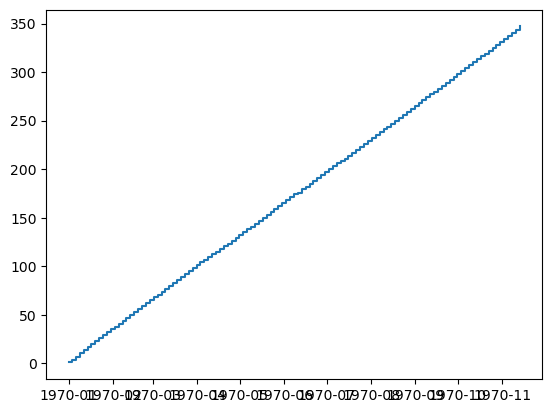

In [15]:
fig, ax = plt.subplots()
ax.plot(dfs[1]['Timestamp'], dfs[1]['ActivityID'])

In [21]:
df_hubs = dfs[0]
df_no_hubs = dfs[1]

df_hubs["SourceLevel"] = df_hubs['Meta'].apply(lambda x: x['source_level'])
df_no_hubs["SourceLevel"] = df_no_hubs['Meta'].apply(lambda x: x['source_level'])

# ActivityID represents one cycle
df_hubs["ActivityID"] = pd.factorize(df_hubs["ActivityID"])[0]
df_no_hubs["ActivityID"] = pd.factorize(df_no_hubs["ActivityID"])[0]

In [22]:
df_hubs_rtm_nij = df_hubs[df_hubs['Ship'] == 'RTM-NIJ']
df_hubs_nij_dui = df_hubs[df_hubs['Ship'] == 'NIJ-DUI']

df_hubs_rtm_nij["ActivityID"] = pd.factorize(df_hubs_rtm_nij["ActivityID"])[0]
df_hubs_nij_dui["ActivityID"] = pd.factorize(df_hubs_nij_dui["ActivityID"])[0]

df_no_hubs_rtm_dui = df_no_hubs[df_no_hubs['Ship'] == 'RTM-DUI']

In [23]:
color_rtm_nij = np.array([37, 40, 61]) / 255
color_nij_dui = np.array([183, 79, 111]) / 255
color_rtm_dui = np.array([117, 221, 221]) / 255

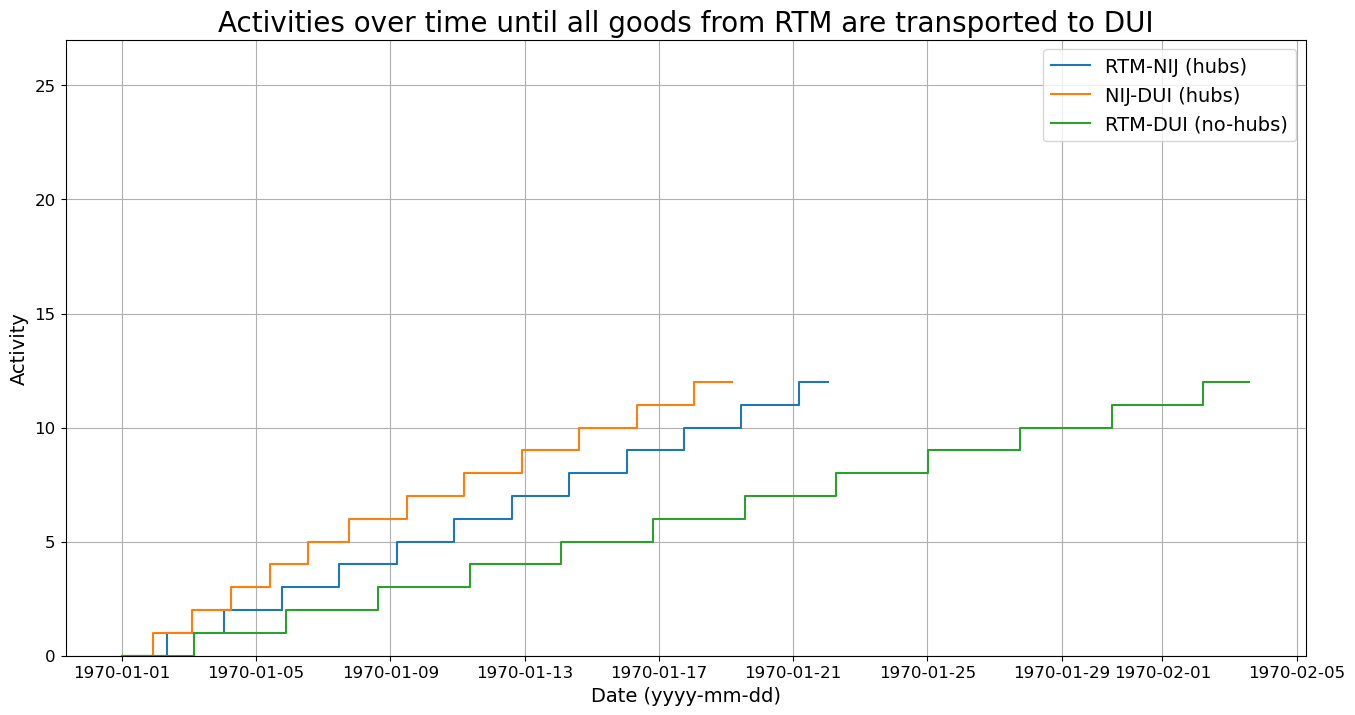

In [24]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(df_hubs_rtm_nij['Timestamp'][:100], df_hubs_rtm_nij['ActivityID'][:100], label='RTM-NIJ (hubs)')
ax.plot(df_hubs_nij_dui['Timestamp'][:100], df_hubs_nij_dui['ActivityID'][:100], label='NIJ-DUI (hubs)')
ax.plot(df_no_hubs_rtm_dui['Timestamp'][:100], df_no_hubs_rtm_dui['ActivityID'][:100], label='RTM-DUI (no-hubs)')

ax.set_xlabel('Date (yyyy-mm-dd)', size=14)
ax.set_ylabel('Activity', size=14)

ax.set_xlabel('Date (yyyy-mm-dd)', size=14)
ax.set_ylabel('Activity', size=14)

ax.set_ylim(0, 27)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.set_title("Activities over time until all goods from RTM are transported to DUI", size=20)

ax.grid()
ax.legend(prop={'size': 14})

# plt.savefig(fig_dir / 'zoomed-in-activities-comparison.png')

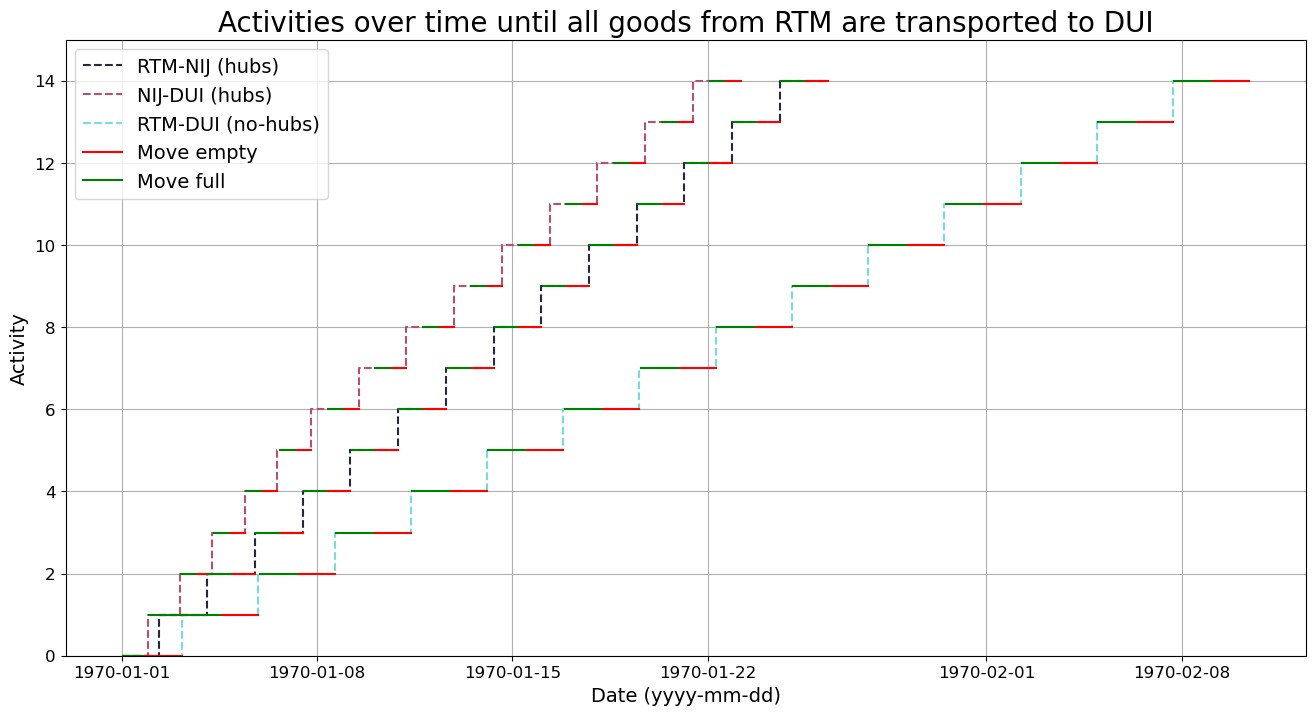

In [25]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(df_hubs_rtm_nij['Timestamp'][:120], df_hubs_rtm_nij['ActivityID'][:120], label='RTM-NIJ (hubs)', color=color_rtm_nij, linestyle='--')
ax.plot(df_hubs_nij_dui['Timestamp'][:120], df_hubs_nij_dui['ActivityID'][:120], label='NIJ-DUI (hubs)', color=color_nij_dui, linestyle='--')
ax.plot(df_no_hubs_rtm_dui['Timestamp'][:120], df_no_hubs_rtm_dui['ActivityID'][:120], label='RTM-DUI (no-hubs)', color=color_rtm_dui, linestyle='--')
for i in range(0, 30, 2):
    if i == 0:
        label_1 = 'Move empty'
        label_2 = 'Move full'
    else:
        label_1 = None
        label_2 = None
    ax.plot(
        [df_hubs_rtm_nij[df_hubs_rtm_nij['Message'] == 'move empty']['Timestamp'].iloc[i], df_hubs_rtm_nij[df_hubs_rtm_nij['Message'] == 'move empty']['Timestamp'].iloc[i+1]],
        [df_hubs_rtm_nij[df_hubs_rtm_nij['Message'] == 'move empty']['ActivityID'].iloc[i], df_hubs_rtm_nij[df_hubs_rtm_nij['Message'] == 'move empty']['ActivityID'].iloc[i+1]],
        color='r', label=label_1
    )
    ax.plot(
        [df_hubs_nij_dui[df_hubs_nij_dui['Message'] == 'move empty']['Timestamp'].iloc[i], df_hubs_nij_dui[df_hubs_nij_dui['Message'] == 'move empty']['Timestamp'].iloc[i+1]],
        [df_hubs_nij_dui[df_hubs_nij_dui['Message'] == 'move empty']['ActivityID'].iloc[i], df_hubs_nij_dui[df_hubs_nij_dui['Message'] == 'move empty']['ActivityID'].iloc[i+1]],
        color='r'
    )
    ax.plot(
        [df_no_hubs_rtm_dui[df_no_hubs_rtm_dui['Message'] == 'move empty']['Timestamp'].iloc[i], df_no_hubs_rtm_dui[df_no_hubs_rtm_dui['Message'] == 'move empty']['Timestamp'].iloc[i+1]],
        [df_no_hubs_rtm_dui[df_no_hubs_rtm_dui['Message'] == 'move empty']['ActivityID'].iloc[i], df_no_hubs_rtm_dui[df_no_hubs_rtm_dui['Message'] == 'move empty']['ActivityID'].iloc[i+1]],
        color='r'
    )

    ax.plot(
        [df_hubs_rtm_nij[df_hubs_rtm_nij['Message'] == 'move full']['Timestamp'].iloc[i], df_hubs_rtm_nij[df_hubs_rtm_nij['Message'] == 'move full']['Timestamp'].iloc[i+1]],
        [df_hubs_rtm_nij[df_hubs_rtm_nij['Message'] == 'move full']['ActivityID'].iloc[i], df_hubs_rtm_nij[df_hubs_rtm_nij['Message'] == 'move full']['ActivityID'].iloc[i+1]],
        color='g', label=label_2
    )
    ax.plot(
        [df_hubs_nij_dui[df_hubs_nij_dui['Message'] == 'move full']['Timestamp'].iloc[i], df_hubs_nij_dui[df_hubs_nij_dui['Message'] == 'move full']['Timestamp'].iloc[i+1]],
        [df_hubs_nij_dui[df_hubs_nij_dui['Message'] == 'move full']['ActivityID'].iloc[i], df_hubs_nij_dui[df_hubs_nij_dui['Message'] == 'move full']['ActivityID'].iloc[i+1]],
        color='g'
    )
    ax.plot(
        [df_no_hubs_rtm_dui[df_no_hubs_rtm_dui['Message'] == 'move full']['Timestamp'].iloc[i], df_no_hubs_rtm_dui[df_no_hubs_rtm_dui['Message'] == 'move full']['Timestamp'].iloc[i+1]],
        [df_no_hubs_rtm_dui[df_no_hubs_rtm_dui['Message'] == 'move full']['ActivityID'].iloc[i], df_no_hubs_rtm_dui[df_no_hubs_rtm_dui['Message'] == 'move full']['ActivityID'].iloc[i+1]],
        color='g'
    )

ax.set_xlabel('Date (yyyy-mm-dd)', size=14)
ax.set_ylabel('Activity', size=14)

ax.set_xlabel('Date (yyyy-mm-dd)', size=14)
ax.set_ylabel('Activity', size=14)

ax.set_ylim(0, 15)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.set_title("Activities over time until all goods from RTM are transported to DUI", size=20)

ax.grid()
ax.legend(prop={'size': 14})

plt.savefig(fig_dir / 'zoomed-in-activities-comparison.png')

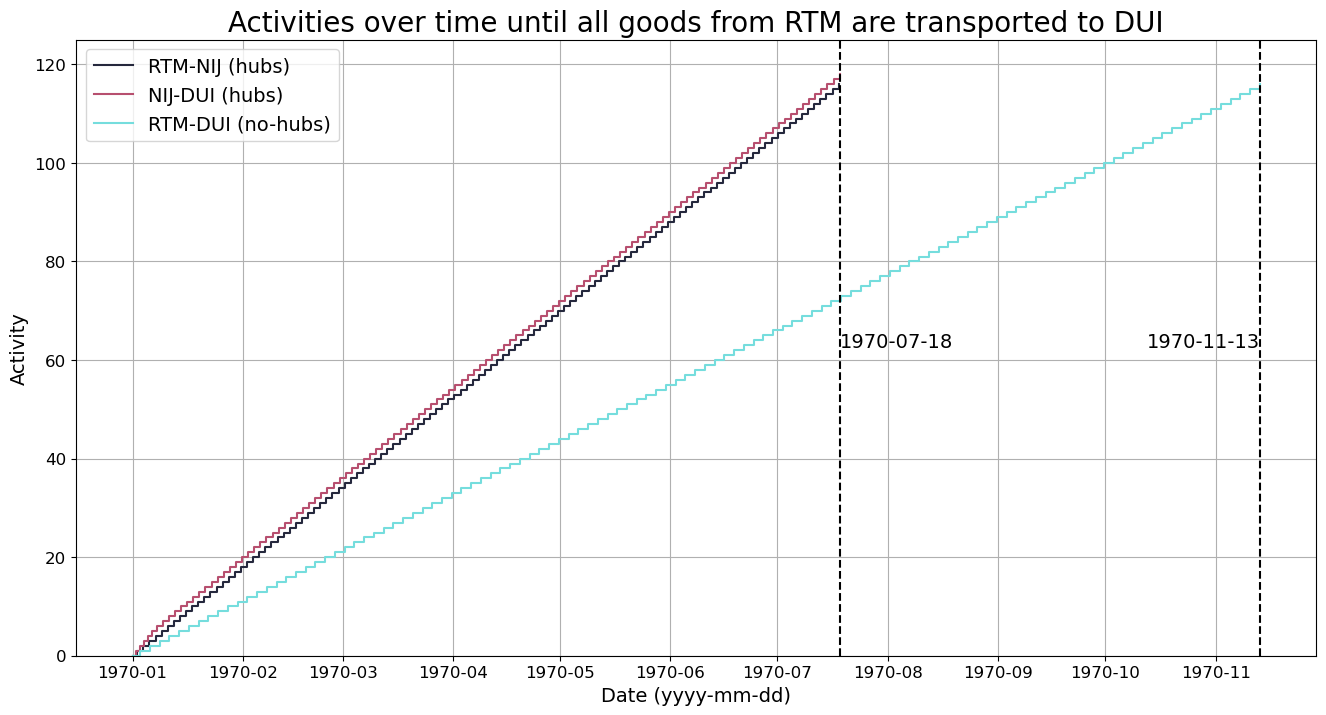

In [26]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(df_hubs_rtm_nij['Timestamp'], df_hubs_rtm_nij['ActivityID'], label='RTM-NIJ (hubs)', color=color_rtm_nij)
ax.plot(df_hubs_nij_dui['Timestamp'], df_hubs_nij_dui['ActivityID'], label='NIJ-DUI (hubs)', color=color_nij_dui)
ax.plot(df_no_hubs_rtm_dui['Timestamp'], df_no_hubs_rtm_dui['ActivityID'], label='RTM-DUI (no-hubs)', color=color_rtm_dui)

ax.plot([df_hubs['Timestamp'].iloc[len(df_hubs) - 1], df_hubs['Timestamp'].iloc[len(df_hubs) - 1]], [0, 250], linestyle='--', color='black')
ax.text(df_hubs['Timestamp'].iloc[len(df_hubs) - 1], 62.5, df_hubs['Timestamp'].iloc[len(df_hubs) - 1].strftime('%Y-%m-%d'), size=14)

ax.plot([df_no_hubs['Timestamp'].iloc[len(df_no_hubs) - 1], df_no_hubs['Timestamp'].iloc[len(df_no_hubs) - 1]], [0, 250], linestyle='--', color='black')
ax.text(df_no_hubs['Timestamp'].iloc[len(df_no_hubs) - 1], 62.5, df_no_hubs['Timestamp'].iloc[len(df_no_hubs) - 1].strftime('%Y-%m-%d'), horizontalalignment='right', size=14)

ax.set_xlabel('Date (yyyy-mm-dd)', size=14)
ax.set_ylabel('Activity', size=14)

ax.set_ylim(0, 125)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.set_title("Activities over time until all goods from RTM are transported to DUI", size=20)

ax.grid()
ax.legend(prop={'size': 14})

plt.savefig(fig_dir / 'all-activities-comparison.png')